In [ ]:
# Imports
from fake_useragent import UserAgent

## Testing "link_extractor"

In [ ]:
import pandas as pd
from etl_pipeline.link_extractor import Google, Bing, Yahoo

### Testing Google class

In [ ]:
google = Google(company="UBS")
google_links = google.get_links(max_articles=20)

In [ ]:
google_links.head()

### Testing Bing class

In [ ]:
bing = Bing(company="UBS")
bing_links = bing.get_links(max_articles=20)

In [ ]:
bing_links.head()

### Testing Yahoo class

In [ ]:
yahoo = Yahoo(company="UBS")
yahoo_links = yahoo.get_links(max_articles=20)

In [ ]:
yahoo_links.head()

## Testing "html_content_extractor2"

### Combine links from Google, Bing, and Yahoo

In [ ]:
links = pd.concat([google_links, bing_links, yahoo_links])

In [ ]:
links["Search Engine"].value_counts()

In [ ]:
links["Link"].duplicated().sum()

In [ ]:
urls = links["Link"].drop_duplicates().to_list()
len(urls)

In [ ]:
from etl_pipeline.content_extractor import get_content

In [ ]:
results = get_content(urls)

In [ ]:
results.head()

## Some NLP Preprocessing

In [ ]:
len(results)

In [ ]:
data = results.loc[results["Body"].str.strip().astype(bool)].reset_index(drop=True)

In [ ]:
# Why would you ever make a string column boolean?
x = ""
bool(x)

In [ ]:
len(data)

In [ ]:
data.head()

In [12]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings("ignore")

import string
import nltk
# Import the stop word list
from nltk.corpus import stopwords
nltk.download("stopwords")
# Import Tokenizer
from nltk.tokenize import RegexpTokenizer
#Import Lemmatizer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
# Import stemmer.
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/johnbergmann/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/johnbergmann/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Average Wordcount before pre-processing
data["Body"].apply(lambda x: len(x.split())).mean()

In [ ]:
# Total Wordcount before pre-processing
data["Body"].apply(lambda x: len(x.split())).sum()

### Remove Numbers (We are doing reputational NLP so doesnt seem relevant)

In [9]:
def remove_numbers(text):
    no_nums = "".join([i for i in text if not i.isdigit()])
    return no_nums

In [ ]:
data["Body"] = data["Body"].apply(lambda x: remove_numbers(x))
data["Body"].head(10)

### Removing extra whitespaces / new lines

In [ ]:
data["Body"] = data["Body"].replace(r'\n'," ", regex=True)

### Removing Punctuation

In [10]:
def remove_punctuation(text):
    no_punct = "".join ([c for c in text if c not in string.punctuation])
    return no_punct

In [ ]:
data["Body"] = data["Body"].apply(lambda x: remove_punctuation(x))
data["Body"].head(10)

### Tokenization

In [13]:
tokenizer = RegexpTokenizer(r'\w+')

In [ ]:
data["Body"] = data["Body"].apply(lambda x: tokenizer.tokenize(x.lower()))
data["Body"].head(10)

### Removing Stopwords

In [14]:
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words("english")]
    return words

In [ ]:
data["Body"] = data["Body"].apply(lambda x: remove_stopwords(x))
data["Body"].head(10)

### Lemmatization

In [15]:
lemmatizer = WordNetLemmatizer()

In [16]:
def word_lemmatizer(text):
    lem_text = [lemmatizer.lemmatize (i) for i in text]
    return lem_text

In [ ]:
data["Body"] = data["Body"].apply(lambda x: word_lemmatizer(x))
data["Body"].head(10)

In [ ]:
# Average Wordcount after pre-processing
data["Body"].apply(lambda x: len(x)).mean()

In [ ]:
# Total Wordcount after pre-processing
data["Body"].apply(lambda x: len(x)).sum()

### Encoding

In [ ]:
text = data["Body"].apply(lambda x: " ".join(x)).str.cat()

In [ ]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)

In [ ]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate (chars) }
itos = { i:ch for i,ch in enumerate (chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''. join ( [itos [i] for i in l]) # decoder: take a list of integers, output a string
print (encode("hii there"))
print (decode(encode("hii there")))

### Wordcloud - Test

In [17]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [ ]:
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Wordcloud on Titles only

In [ ]:
data["Title"] = data["Title"].apply(lambda x: remove_numbers(x))
data["Title"] = data["Title"].replace(r'\n'," ", regex=True)
data["Title"] = data["Title"].apply(lambda x: remove_punctuation(x))
data["Title"] = data["Title"].apply(lambda x: tokenizer.tokenize(x.lower()))
data["Title"] = data["Title"].apply(lambda x: remove_stopwords(x))
data["Title"] = data["Title"].apply(lambda x: word_lemmatizer(x))

In [ ]:
title_text = data["Title"].apply(lambda x: " ".join(x)).str.cat()

In [ ]:
# Create and generate a word cloud image:
title_wordcloud = WordCloud().generate(title_text)

# Display the generated image:
plt.imshow(title_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Multithreading Implementation Test

In [1]:
from etl_pipeline.link_extractor import get_all_links # Might make sense to make Search Engines seperate file for clarity
from etl_pipeline.content_extractor import get_content

In [2]:
# max_articles is for each search engine
ubs = get_all_links(company="Donald Trump", max_articles=100, threads=10)
ubs["Search Engine"].value_counts()

Bing      100
Google    100
Yahoo      20
Name: Search Engine, dtype: int64

In [3]:
ubs.head()

,Search Engine,Link,Title,Source
0,Yahoo,https://www.msn.com/en-us/news/politics/is-don...,Is Donald Trump In âCognitive Declineâ?,MSN News
1,Yahoo,https://www.newsweek.com/donald-trump-jr-spark...,Donald Trump Jr. sparks MAGA fury with Bud Lig...,Newsweek
2,Yahoo,https://news.yahoo.com/donald-trump-marjorie-t...,"Donald Trump, Marjorie Taylor Greene and Ron D...",USA TODAY Opinion via Yahoo News
3,Yahoo,https://www.newsweek.com/trump-lawyers-recusal...,Trump lawyer's recusal spells bad new for form...,Newsweek
4,Yahoo,https://news.yahoo.com/rare-glimpse-melania-tr...,"A rare glimpse of Melania Trump, seen smiling ...",INSIDER via Yahoo News


In [4]:
urls = ubs["Link"].drop_duplicates().to_list()
len(urls)

204

In [23]:
results = get_content(urls)

Getting news article info:   1%|▏         | 3/204 [00:00<00:34,  5.89it/s]encoding error : input conversion failed due to input error, bytes 0x44 0x00 0x00 0x00
I/O error : encoder error
Getting news article info:  17%|█▋        | 34/204 [00:02<00:11, 15.09it/s]encoding error : input conversion failed due to input error, bytes 0x21 0x00 0x00 0x00
encoding error : input conversion failed due to input error, bytes 0x64 0x00 0x00 0x00
I/O error : encoder error
Getting news article info:  25%|██▍       | 50/204 [00:03<00:12, 12.68it/s]encoding error : input conversion failed due to input error, bytes 0x21 0x00 0x00 0x00
encoding error : input conversion failed due to input error, bytes 0x64 0x00 0x00 0x00
I/O error : encoder error
Getting news article info:  39%|███▊      | 79/204 [00:05<00:07, 16.43it/s]encoding error : input conversion failed due to input error, bytes 0x21 0x00 0x00 0x00
encoding error : input conversion failed due to input error, bytes 0x44 0x00 0x00 0x00
I/O error : en

In [24]:
len(results)

188

In [6]:
data = results.loc[results["Body"].str.strip().astype(bool)].reset_index(drop=True)

In [18]:
data["Body"] = data["Body"].apply(lambda x: remove_numbers(x))
data["Body"] = data["Body"].replace(r'\n'," ", regex=True)
data["Body"] = data["Body"].apply(lambda x: remove_punctuation(x))
data["Body"] = data["Body"].apply(lambda x: tokenizer.tokenize(x.lower()))
data["Body"] = data["Body"].apply(lambda x: remove_stopwords(x))
data["Body"] = data["Body"].apply(lambda x: word_lemmatizer(x))

In [19]:
body_text = data["Body"].apply(lambda x: " ".join(x)).str.cat()

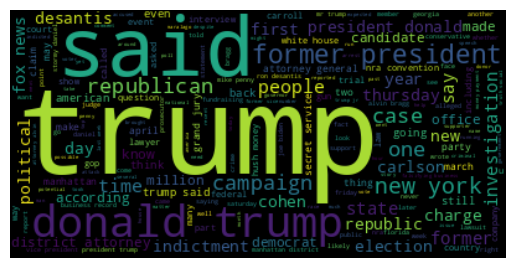

In [20]:
# Create and generate a word cloud image:
title_wordcloud = WordCloud().generate(body_text)

# Display the generated image:
plt.imshow(title_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [22]:
len(body_text)

431669